# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt   
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
credit = pd.read_csv('project_data.csv', delimiter=';')
credit.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
credit['Y'].value_counts()

1    700
2    300
Name: Y, dtype: int64

# Data Processing

In [4]:
credit['Y'] = credit['Y'].map({1:0, 2: 1})

In [5]:
credit['Y'].value_counts()

0    700
1    300
Name: Y, dtype: int64

In [6]:
continuous_vars = ['X02',  'X05', 'X13','X11','X16', 'X18','X08']
categorical_vars=['X04','X09','X10','X12','X14','X15','X01','X03','X06','X07','X17','X19','X20']
nominal=['X04','X09','X10','X12','X14','X15']
ordinal=['X01','X03','X06','X07','X17']

In [7]:
credit['X01'] = credit['X01'].map({'A14':0, 'A11':1, 'A12':2, 'A13':3})
credit['X03'] = credit['X03'].map({'A30':0, 'A31':1, 'A32':2, 'A33':3,'A34':4})
credit['X06'] = credit['X06'].map({'A65':0, 'A61':1, 'A62':2, 'A63':3,'A64':4})
credit['X07'] = credit['X07'].map({'A71':0, 'A72':1, 'A73':2, 'A74':3,'A75':4})
credit['X17'] = credit['X17'].map({'A171':0, 'A172':1, 'A173':2, 'A174':3})
credit['X19'] = credit['X19'].map({'A191':0, 'A192':0})
credit['X20'] = credit['X20'].map({'A201':1, 'A202':0})

In [8]:
le = LabelEncoder()
credit[nominal] = credit[nominal].apply(le.fit_transform)

In [9]:
from scipy.stats import chi2_contingency, ttest_ind

feature = []
p = []
chi_2 = []

for i in categorical_vars[:-1]:
    feature.append(i)
    result =chi2_contingency( pd.crosstab(credit['Y'],credit[i]))
    p.append(round(float(result[1]),6))   
    if float(result[1]) < 0.01:
        chi_2.append("Significant")
    else:
        chi_2.append("Insignificant")

In [10]:
chi = pd.DataFrame(data={'P value':p,'Significance':chi_2},index=feature)
chi

,P value,Significance
X04,0.000116,Significant
X09,0.022238,Insignificant
X10,0.036056,Insignificant
X12,0.000029,Significant
X14,0.001629,Significant
X15,0.000112,Significant
X01,0.000000,Significant
X03,0.000000,Significant
X06,0.000000,Significant
X07,0.001045,Significant


In [11]:
def t_test(df,columns):    
    feature = []
    p = []
    t_test = []
    
    for i in columns:
        feature.append(i)
        result = ttest_ind(df[df["Y"]==0][i], df[df["Y"]==1][i])
        p.append(round(float(result[1]),6))
        
        if float(result[1]) < 0.01:
            t_test.append("Significant")
        else:
            t_test.append("Insignificant")
    
    return(pd.DataFrame(index=feature,data={'P Value':p,'Significance':t_test}))

In [12]:
df_t_test = t_test(credit, continuous_vars)
df_t_test

,P Value,Significance
X02,0.000000,Significant
X05,0.000001,Significant
X13,0.003925,Significant
X11,0.925337,Insignificant
X16,0.148420,Insignificant
X18,0.924141,Insignificant
X08,0.022035,Insignificant


In [13]:
credit = credit.drop(columns = chi[chi['Significance'] == 'Insignificant'].index, axis=1)

In [14]:
credit = credit.drop(columns = df_t_test[df_t_test['Significance'] == 'Insignificant'].index, axis=1)

In [15]:
x = credit.drop(['Y'],axis=1)
y = credit['Y']

### Split data into Training, Validation and Test Sets

In [16]:
x_train1, x_test, y_train1, y_test = train_test_split(x, y, test_size=0.2, stratify=y,random_state=10)

In [17]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train1, y_train1, test_size=0.2, stratify = y_train1,random_state=10)

# Oversampling minority

In [18]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=1)
x_train, y_train = oversample.fit_resample(x_train, y_train)

### Normalize numerical features

In [19]:
mm = MinMaxScaler()
x_train[['X02','X05','X13']] = mm.fit_transform(x_train[['X02','X05','X13']])
x_valid[['X02','X05','X13']]= mm.fit_transform(x_valid[['X02','X05','X13']])
x_test[['X02','X05','X13']] = mm.fit_transform(x_test[['X02','X05','X13']])

## Modeling

In [20]:
from sklearn.model_selection import StratifiedKFold
skfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)

In [21]:
from scipy.stats import randint

# DecisionTree Classifier
tree_params = { 'criterion': ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'max_depth': range(2, 10)}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params,scoring="recall",cv=skfold, n_jobs=-1)
grid_tree.fit(x_train, y_train)
tree_clf = grid_tree.best_estimator_
  

#Logistic regression
logreg_grid={ 'C':[0.0001,0.001,0.01,0.1,1,10,100,1000], 'max_iter':[100,1000,2500],'penalty':['l1','l2'], 'solver':["liblinear","saga"]}
grid_logreg = GridSearchCV(LogisticRegression(), logreg_grid,scoring="recall",cv=skfold, n_jobs=-1)
grid_logreg.fit(x_train, y_train)
logreg = grid_logreg.best_estimator_

In [22]:
grid_logreg.best_params_

{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [23]:
grid_tree.best_params_

{'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}

In [24]:
preds_logreg = logreg.predict(x_valid)
print("logreg: recall:",round(recall_score(y_valid,preds_logreg),3)," precision:",round(precision_score(y_valid,preds_logreg),3))

logreg: recall: 0.896  precision: 0.426


In [25]:
preds_tree = tree_clf.predict(x_valid)
print("Decision tree: recall:",round(recall_score(y_valid,preds_tree),3)," precision:",round(precision_score(y_valid,preds_tree),3))

Decision tree: recall: 0.938  precision: 0.464


##  Model Selection: Decision tree

In [26]:
final_model=tree_clf.fit(x_train,y_train)
preds = final_model.predict(x_test)
print('Recall:',round(recall_score(y_test,preds),3))

Recall: 0.85


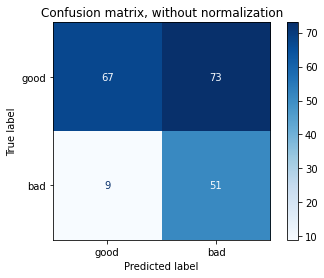

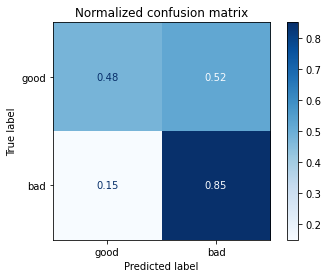

In [27]:
from sklearn.metrics import plot_confusion_matrix,classification_report

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree_clf, x_test, y_test,
                                 display_labels=['good','bad'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)


plt.show()

In [28]:
preds = tree_clf.predict(x_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.48      0.62       140
           1       0.41      0.85      0.55        60

    accuracy                           0.59       200
   macro avg       0.65      0.66      0.59       200
weighted avg       0.74      0.59      0.60       200



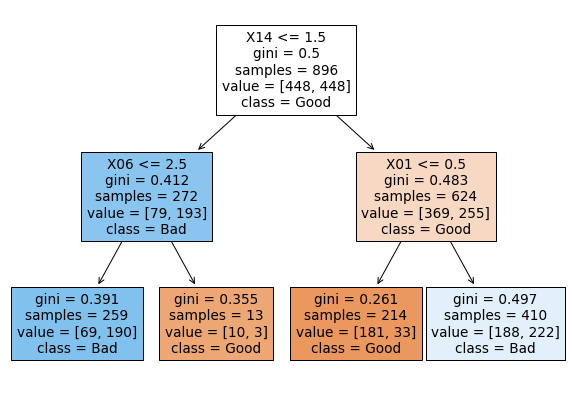

In [29]:
from sklearn import tree
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(tree_clf, 
                   feature_names=x.columns,  
                   class_names=['Good','Bad'],
                    filled=True)

In [30]:
feature_importance=pd.DataFrame(data={'Feature':x_train.columns,'Importance':tree_clf.feature_importances_})
feature_importance=feature_importance.sort_values(by='Importance',ascending=False)

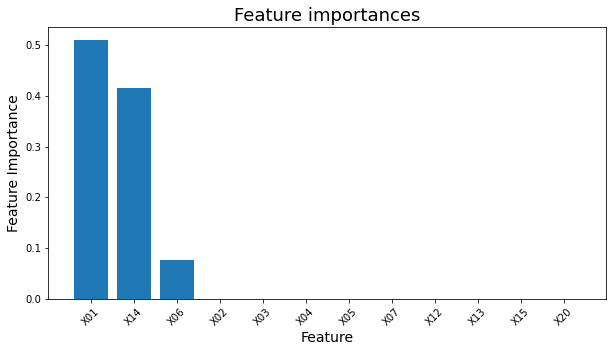

In [31]:
plt.figure(figsize=(10,5))
plt.bar(x=feature_importance['Feature'],height=feature_importance['Importance'])
plt.title("Feature importances",size=18)
plt.ylabel("Feature Importance", size=14)
plt.xlabel("Feature", size=14)
plt.xticks(rotation=45)
plt.show()

In [32]:
feature_importance['Importance']

0     0.509738
9     0.414608
5     0.075655
1     0.000000
2     0.000000
3     0.000000
4     0.000000
6     0.000000
7     0.000000
8     0.000000
10    0.000000
11    0.000000
Name: Importance, dtype: float64